# Statistics notebook: Shared States
Accompanying the manuscript "Shared states: Using MVPA to test neural overlap between self-focused emotion imagery and other-focused emotion understanding" (Oosterwijk, Snoek, Rotteveel, Barrett, & Scholte, submitted)

Lukas Snoek, February 2016 | lukassnoek@gmail.com <br>
https://github.com/lukassnoek/DecodingEmotions

### Code for main analysis
The code written for the main analysis (i.e. classification analysis of both the self-data and the generalization to the other-data) in contained in scripts hosted at the above Github repository.



In [1]:
from __future__ import division, print_function
import cPickle
import os
import glob
import os.path as op
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import itertools

%matplotlib inline

plot_dir = '/home/lukas/Dropbox/PhD_projects/DecodingEmotions_SCAN/Plots'

The function below transforms 'raw' confusion matrics (in which the numbers indicate the number of trials assigned to a particular class, with the x-axis referring to the predicted class and the y-axis referring to the true class). The metrics precision (also known as Positive Predictive Value), recall (also known as the True Positive Rate), and F1-score (harmonic mean between precision and recall) are supported. In the article, precision-scores are reported.

In [2]:
def compute_score_confmat(confmat, metric='precision'):
    
    if metric == 'precision':
            return confmat / confmat.sum(axis=0)
    elif metric == 'recall':
        return confmat / confmat.sum(axis=1)
    elif metric == 'F1':
        precision = confmat / confmat.sum(axis=0)
        recall = confmat / confmat.sum(axis=1)
        return 2 * (recall * precision) / (recall + precision)               

# MAIN ARTICLE: STATISTICS & PLOTS
Below, the results from the validation set (as reported in the main article) are computed. The results from the optimization procedure and final analysis on the (final) optimization set are listed in section 2: SUPPLEMENTARY MATERIALS.

In [3]:
# Location of results from 100,000 iterations analysis
self_dir = '/media/lukas/data/DecodingEmotions/Validation_set/glm_zinnen/100000iter_results'
other_dir = '/media/lukas/data/DecodingEmotions/Validation_set/glm_HWW/100000iter_results'

## 1. Statistics of self-analysis
Below, we load in the subject-specific confusion matrices and convert the 'raw' metrics to more easily interpretable 'precision' scores:

$$ precision = \frac{true\ positives}{true\ positives + false\ positives} $$

The resulting ndarray thus contains precision-matrices for each subject, of which the average is plotted below.

In [6]:
self_files = glob.glob(op.join(self_dir, '*.pickle'))
s_confmat = np.zeros((len(self_files), 3, 3))
for i, f in enumerate(self_files):
    tmp = cPickle.load(open(f)).conf_mat
    s_confmat[i, :, :] = compute_score_confmat(tmp, metric='precision')

s_confmat[np.isnan(s_confmat)] = 0

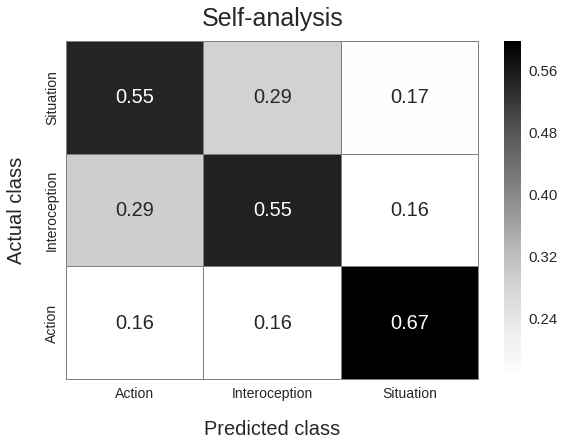

In [7]:
labels = ['Action', 'Interoception', 'Situation']
s_av_cm = s_confmat.mean(axis=0)
plt.figure(figsize=(8,6))
ax = sns.heatmap(s_av_cm, cmap=plt.cm.Greys, annot=True,
                 linewidths=0.1, linecolor='grey', vmax=.6, cbar=True, annot_kws={'fontsize': 20})
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
plt.xticks(np.arange(3)+0.5, labels, fontsize=14)
plt.yticks(np.arange(3)+0.5, labels, fontsize=14)
plt.xlabel('Predicted class', fontsize=20, labelpad=19)
plt.ylabel('Actual class', fontsize=20, labelpad=19)
plt.title('Self-analysis', fontsize=25, y=1.03)
plt.tight_layout(pad=0.1)
plt.savefig(op.join(plot_dir, 'self_confmat.png'))

In [14]:
# Loading in permutation confusion matrices
s_perm_dir = '/media/lukas/data/DecodingEmotions/Validation_set/glm_zinnen/permutation_results/'
s_dirs = glob.glob(op.join(s_perm_dir, 'perm_*'))
n = s_confmat.shape[0]

s_perm_mats = np.zeros((len(s_dirs), n, 3, 3))

for i, d in enumerate(s_dirs):
    mats = glob.glob(op.join(d, '*confmat.npy'))
    
    for ii, m in enumerate(mats):
        s_perm_mats[i, ii, :, :] = compute_score_confmat(np.load(m))

In [13]:
# Significance: p-value = nr of perms above observed score / nr of total perms
# see: Nichols, T. E., & Holmes, A. P. (2002). Nonparametric permutation tests for functional neuroimaging: 
# a primer with examples. Human brain mapping, 15(1), 1-25
s_av_perm_mats = s_perm_mats.mean(axis=1)
s_p_cm = np.round((s_confmat.mean(axis=0) < s_av_perm_mats).sum(axis=0) / s_av_perm_mats.shape[0], 3)
print(s_p_cm)

[[ 0.     0.999  1.   ]
 [ 0.998  0.     1.   ]
 [ 1.     1.     0.   ]]


## 2. Statistics of cross-analysis

In [15]:
other_files = glob.glob(op.join(other_dir, '*.pickle'))
o_confmat = np.zeros((len(other_files), 3, 3))
for i, f in enumerate(other_files):
    tmp = cPickle.load(open(f)).conf_mat
    o_confmat[i, :, :] = compute_score_confmat(tmp, metric='precision')
o_confmat[np.isnan(o_confmat)] = 0

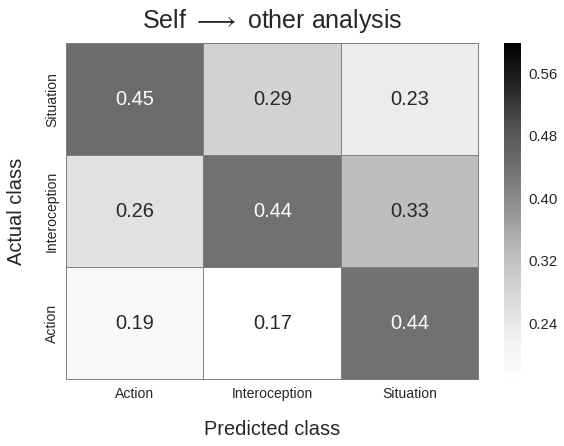

In [16]:
o_av_cm = o_confmat.mean(axis=0)
plt.figure(figsize=(8,6))
ax = sns.heatmap(o_av_cm, cmap=plt.cm.Greys, annot=True,
                 linewidths=0.1, linecolor='grey', vmax=.6, cbar=True, annot_kws={'fontsize': 20})
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
plt.xticks(np.arange(3)+0.5, labels, fontsize=14)
plt.yticks(np.arange(3)+0.5, labels, fontsize=14)
plt.xlabel('Predicted class', fontsize=20, labelpad=19)
plt.ylabel('Actual class', fontsize=20, labelpad=19)
plt.title('Self $\longrightarrow$ other analysis', fontsize=25, y=1.03)
plt.tight_layout(pad=0.1)
plt.savefig(op.join(plot_dir, 'cross_confmat.png'))

In [18]:
o_perm_dir = '/media/lukas/data/DecodingEmotions/Validation_set/glm_HWW/permutation_results/'
o_dirs = glob.glob(op.join(o_perm_dir, 'perm_*'))

# perm_mats shape = [nr perms, subjects, n_class, n_class]
o_perm_mats = np.zeros((len(o_dirs), o_confmat.shape[0], 3, 3))

for i, d in enumerate(o_dirs):
    mats = glob.glob(op.join(d, '*confmat.npy'))
    for ii, m in enumerate(mats):
        o_perm_mats[i, ii, :, :] = compute_score_confmat(np.load(m), 'precision')

In [570]:
o_av_perm_mats = o_perm_mats.mean(axis=1)
o_p_cm = np.round((o_confmat.mean(axis=0) < o_av_perm_mats).sum(axis=0) / o_av_perm_mats.shape[0], 3)
print(o_p_cm)

[[ 0.     0.995  1.   ]
 [ 1.     0.     0.66 ]
 [ 1.     1.     0.   ]]


## 3. Visualizing classification model in voxel-space
Here, the process of creating 'voxel plots' in which model parameters (i.e. linear svm weights) are calculated and backprojected. The weights, here, are the average weights across cross-validation iterations, which
were subsequently averaged across subjects and normalized by each voxel's standard error in terms of its weight, i.e. mean(weight) / std(weight) / sqrt(n_subs-1).

For more information, check the *skbold* package at Github:
https://github.com/lukassnoek/skbold/blob/master/skbold/utils/mvp_utils.py.
The code to keep track of svm weights and subsequently how these are averaged across iterations and subjects is contained in the classes *MvpResults* and *MvpAverageResults* respectively.

In [ ]:
vox_file = op.join(op.dirname(self_dir), 'redo_voxelplots_COEF_ovo', 'AverageScores.nii')
vox_data = nib.load(vox_file).get_data()

names = ['act_vs_int', 'act_vs_sit', 'int_vs_sit']

# here, both the contrast (e.g. act > int) and its reverse (int > act) is calculated,
# to help visualization in fslview

for i in range(vox_data.shape[-1]):
    tmp = vox_data[:, :, :, i]
    tmp_rev = tmp * -1
    tmp[tmp < 0] = 0
    tmp_rev[tmp_rev < 0] = 0
    
    name = names[i]
    rev_name = "_".join(name.split('_')[::-1])
    nib.save(nib.Nifti1Image(tmp, np.eye(4)), op.join(op.dirname(vox_file), name))
    nib.save(nib.Nifti1Image(tmp_rev, np.eye(4)), op.join(op.dirname(vox_file), rev_name))

## Precision-recall curve


In [571]:
import glob
import os
import warnings
import os.path as op
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from joblib import Parallel, delayed
from skbold.utils.mvp_utils import (MvpResults, MvpAverageResults,
                                         DataHandler)
from skbold.transformers.transformers import *
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score, confusion_matrix

In [572]:
project_dir = '/media/lukas/data/DecodingEmotions/Validation_set'
self_dir = op.join(project_dir, 'glm_zinnen')
other_dir = op.join(project_dir, 'glm_HWW')
self_paths = glob.glob(op.join(self_dir, 'sub*'))
other_paths = glob.glob(op.join(other_dir, 'sub*'))

# Parameters
zvalue = 2.3

scaler = StandardScaler()
transformer = MeanEuclidean(cutoff=zvalue, normalize=True)
clf = SVC(kernel='linear', probability=True, decision_function_shape='ovr')
pipeline = Pipeline([('transformer', transformer),
                     ('scaler', scaler),
                     ('classifier', clf)])
probas = np.zeros((len(self_paths), 90, 3))

for i, (self_path, other_path) in enumerate(zip(self_paths, other_paths)):
    self_data = DataHandler(identifier='merged', shape='2D').load_separate_sub(self_path)
    other_data = DataHandler(identifier='', shape='2D').load_separate_sub(other_path)

    y_ovr = label_binarize(other_data.y, classes=[0, 1, 2])
    pipeline.fit(self_data.X, self_data.y)
    probas[i, :, :] = pipeline.predict_proba(other_data.X)
av_probas = probas.mean(axis=0)


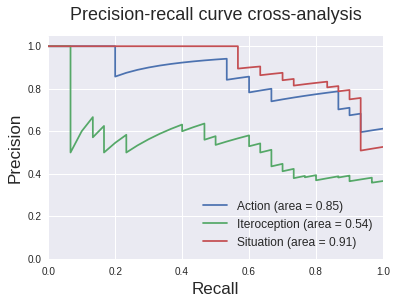

In [573]:
# Credits to the scikit-learn documentation:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
precision = dict()
recall = dict()
average_precision = dict()
n_classes = 3
y_test = y_ovr
y_score = av_probas
labels = ['Action', 'Iteroception', 'Situation']

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

for i in range(n_classes):
    plt.plot(recall[i], precision[i],
             label='{0} (area = {1:0.2f})'
                   ''.format(labels[i], average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=17)
plt.ylabel('Precision', fontsize=17)
plt.title('Precision-recall curve cross-analysis', fontsize=18, y=1.05)
plt.legend(loc="lower right", fontsize=12)

plt.show()

# Optimization set results

In [578]:
# Location of results from 100,000 iterations analysis
optself_dir = '/media/lukas/data/DecodingEmotions/Optimization_set/glm_zinnen/analysis_results'
optother_dir = '/media/lukas/data/DecodingEmotions/Optimization_set/glm_HWW/analysis_results'

In [589]:
optself_files = glob.glob(op.join(optself_dir, '*.pickle'))
opts_confmat = np.zeros((len(optself_files), 3, 3))
for i, f in enumerate(optself_files):
    tmp = cPickle.load(open(f)).conf_mat
    opts_confmat[i, :, :] = compute_score_confmat(tmp, metric='precision')

opts_confmat[np.isnan(opts_confmat)] = 0

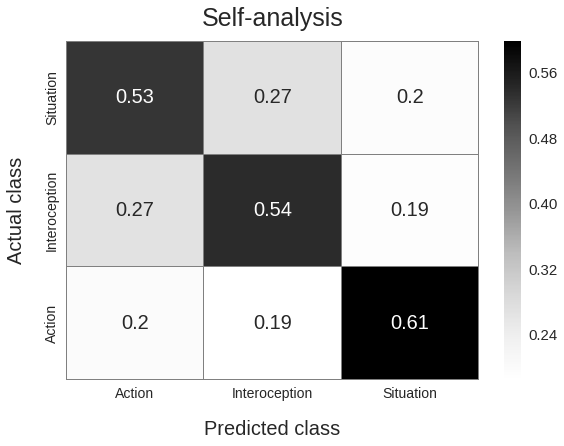

In [590]:
labels = ['Action', 'Interoception', 'Situation']
opts_av_cm = opts_confmat.mean(axis=0)
plt.figure(figsize=(8,6))
ax = sns.heatmap(opts_av_cm, cmap=plt.cm.Greys, annot=True,
                 linewidths=0.1, linecolor='grey', vmax=.6, cbar=True, annot_kws={'fontsize': 20})
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
plt.xticks(np.arange(3)+0.5, labels, fontsize=14)
plt.yticks(np.arange(3)+0.5, labels, fontsize=14)
plt.xlabel('Predicted class', fontsize=20, labelpad=19)
plt.ylabel('Actual class', fontsize=20, labelpad=19)
plt.title('Self-analysis', fontsize=25, y=1.03)
plt.tight_layout(pad=0.1)
plt.savefig(op.join(plot_dir, 'optself_confmat.png'))

In [588]:
optother_files = glob.glob(op.join(optother_dir, '*.pickle'))
opto_confmat = np.zeros((len(optother_files), 3, 3))
for i, f in enumerate(optother_files):
    tmp = cPickle.load(open(f)).conf_mat
    opto_confmat[i, :, :] = compute_score_confmat(tmp, metric='precision')

opto_confmat[np.isnan(opto_confmat)] = 0

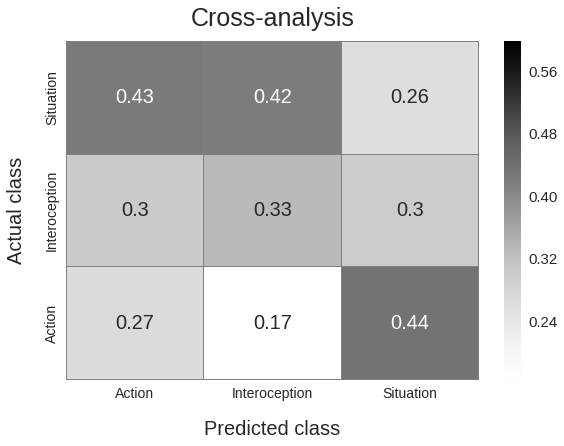

In [592]:
labels = ['Action', 'Interoception', 'Situation']
opto_av_cm = opto_confmat.mean(axis=0)
plt.figure(figsize=(8,6))
ax = sns.heatmap(opto_av_cm, cmap=plt.cm.Greys, annot=True,
                 linewidths=0.1, linecolor='grey', vmax=.6, cbar=True, annot_kws={'fontsize': 20})
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
plt.xticks(np.arange(3)+0.5, labels, fontsize=14)
plt.yticks(np.arange(3)+0.5, labels, fontsize=14)
plt.xlabel('Predicted class', fontsize=20, labelpad=19)
plt.ylabel('Actual class', fontsize=20, labelpad=19)
plt.title('Cross-analysis', fontsize=25, y=1.03)
plt.tight_layout(pad=0.1)
plt.savefig(op.join(plot_dir, 'optother_confmat.png'))